In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"

# 연비 예측 딥러닝 모델 구현
- 실린더 수, 배기량, 마력, 공차 중량 등을 사용하여 MPG 연비를 예측 하는 회귀 모델을 구현
- 수치 예측

# 라이브러리 로드

In [2]:
import matplotlib.pyplot as plt                         # 시각화를 위한 라이브러리
import numpy as np                                      # 연산 등을 위한 라이브러리
import pandas as pd
import seaborn as sns

from tensorflow.keras.layers import Input, Dense, Dropout    # Tensorflow 모델 구성을 위한 라이브러리
from tensorflow.keras.models import Model
import tensorflow as tf

from sklearn.model_selection import train_test_split         # 데이터 전처리를 위한 라이브러리
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# 데이터 로드

In [3]:
dataset_path = tf.keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")

column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)
dataset = raw_dataset.copy()


# 데이터 확인

## 결측 데이터 확인 & 제거

In [4]:
print(dataset.isnull().sum())
dataset = dataset.dropna()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64


## 범주형 데이터에 맞게 데이터 변형

- 실린더 수(Cylinders)
- 배기량(Displacement)
- 마력(Horsepower)
- 공차 중량(Weight)

In [5]:
origin = dataset.pop('Origin')
dataset['USA'] = (origin == 1)*1.0
dataset['Europe'] = (origin == 2)*1.0
dataset['Japan'] = (origin == 3)*1.0
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


# (학습, 시험) 데이터 분리

In [6]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

# 데이터 시각화 & 통계

## 시각화

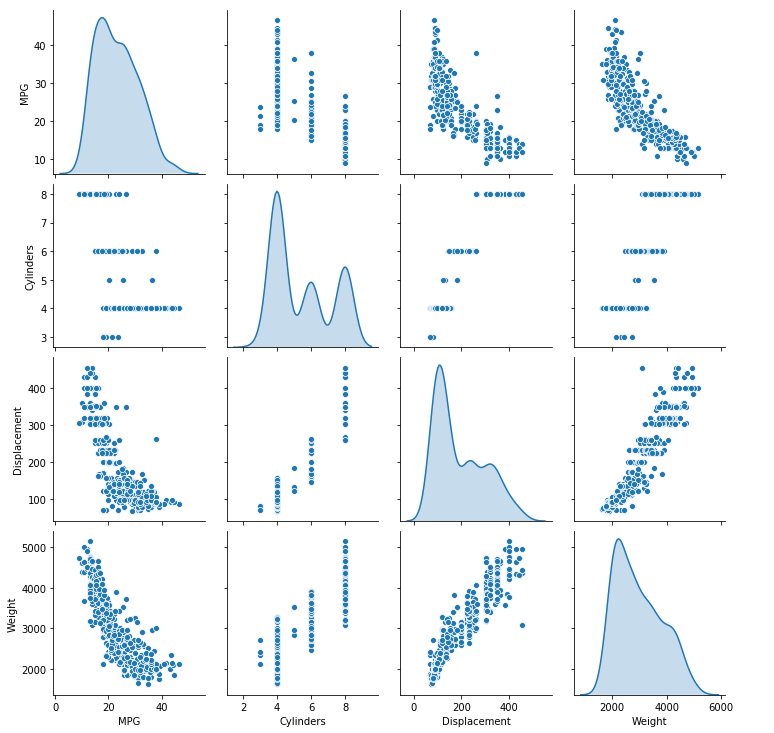

In [7]:
sns.pairplot(dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")


## 통계적 수치

In [8]:
train_stats = dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.T
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,392.0,5.471939,1.705783,3.0,4.000,4.0,8.000,8.0
Displacement,392.0,194.411990,104.644004,68.0,105.000,151.0,275.750,455.0
Horsepower,392.0,104.469388,38.491160,46.0,75.000,93.5,126.000,230.0
Weight,392.0,2977.584184,849.402560,1613.0,2225.250,2803.5,3614.750,5140.0
Acceleration,392.0,15.541327,2.758864,8.0,13.775,15.5,17.025,24.8
Model Year,392.0,75.979592,3.683737,70.0,73.000,76.0,79.000,82.0
USA,392.0,0.625000,0.484742,0.0,0.000,1.0,1.000,1.0
Europe,392.0,0.173469,0.379136,0.0,0.000,0.0,0.000,1.0
Japan,392.0,0.201531,0.401656,0.0,0.000,0.0,0.000,1.0


# 데이터 전처리
- 정답 데이터인 MPG는 훈련해야될 자질 목록에서 제외 시킨다.
- 각 자질끼리 가지는 데이터의 분포가 다르기 때문에 정규화를 시킨다.

## 정답 데이터 분리

In [9]:
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

## 데이터 정규화

In [10]:
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']


normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

# 딥러닝 모델 생성
- 9 개의 값을 입력받는 Input layer를 통해 데이터가 입력된다.
- 64개의 뉴런을 가지는 hidden layer를 두개 쌓은뒤 마지막 층은 1개의 출력을 내도록 구성한다.

In [11]:
def build_model():
    model_input = Input(shape=len(train_dataset.columns))
    hidden = Dense(64, activation='relu', name='Fully_connected_layer1')(model_input)
    hidden = Dense(64, activation='relu', name='Fully_connected_layer2')(hidden)
    model_output = Dense(1, activation='linear')(hidden)
    
    model = Model(model_input, model_output)
    
    model.summary()

    return model

In [12]:

batch_size=4
epochs=1000

decay_st = (len(normed_train_data)//batch_size+1)*epochs
poly_sche = tf.keras.optimizers.schedules.PolynomialDecay(0.001, decay_st, end_learning_rate=1e-6, power=0.9)
opt_poly = tf.keras.optimizers.Adam(poly_sche)

model = build_model()
model.compile(loss='mse', optimizer=opt_poly, metrics=['mae','mse'])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 9)]               0         
_________________________________________________________________
Fully_connected_layer1 (Dens (None, 64)                640       
_________________________________________________________________
Fully_connected_layer2 (Dens (None, 64)                4160      
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


# 데이터들로 모델을 훈련
- 훈련 데이터 중 20%를 검증데이터로 사용한다.
- 학습 데이터만 모델 훈련에 쓸 경우 과적합되어 학습 데이터 이외의 데이터를 테스트할 경우 전혀 다른 결과가 나올 수 있음. 즉, 훈련할 때 보던 데이터만 정확히 맞추는 문제가 발생.
- 검증 데이터를 따로 둠으로써 학습 데이터에만 과적합 되는 것을 방지한다.
- 검증데이터를 만드는 방법은 다양하다. 학습 데이터에서 랜덤으로 10~30% 정도 분리하여 검증 데이터로 만들거나 K개의 Fold로 나누는 K-Fold 방법 등이 있다.

In [13]:
hist = model.fit(normed_train_data, train_labels, epochs=epochs, validation_split=0.2, verbose=1, batch_size=4)

Train on 251 samples, validate on 63 samples
Epoch 1/1000
251/251 [==============================] - 0s 2ms/sample - loss: 488.4944 - mae: 20.4723 - mse: 488.4943 - val_loss: 331.9989 - val_mae: 16.3211 - val_mse: 331.9988
Epoch 2/1000
251/251 [==============================] - 0s 673us/sample - loss: 141.1922 - mae: 9.4438 - mse: 141.1922 - val_loss: 26.7518 - val_mae: 4.1184 - val_mse: 26.7518
Epoch 3/1000
251/251 [==============================] - 0s 643us/sample - loss: 18.1675 - mae: 3.2788 - mse: 18.1675 - val_loss: 15.0228 - val_mae: 2.9162 - val_mse: 15.0228
Epoch 4/1000
251/251 [==============================] - 0s 638us/sample - loss: 12.2713 - mae: 2.5819 - mse: 12.2713 - val_loss: 11.7752 - val_mae: 2.6981 - val_mse: 11.7752
Epoch 5/1000
251/251 [==============================] - 0s 572us/sample - loss: 10.8492 - mae: 2.4089 - mse: 10.8492 - val_loss: 10.2593 - val_mae: 2.5763 - val_mse: 10.2593
Epoch 6/1000
251/251 [==============================] - 0s 615us/sample - loss:

251/251 [==============================] - 0s 633us/sample - loss: 5.7516 - mae: 1.6949 - mse: 5.7516 - val_loss: 8.2450 - val_mae: 2.1803 - val_mse: 8.2450
Epoch 49/1000
251/251 [==============================] - 0s 660us/sample - loss: 6.1637 - mae: 1.7151 - mse: 6.1637 - val_loss: 8.2361 - val_mae: 2.2029 - val_mse: 8.2361
Epoch 50/1000
251/251 [==============================] - 0s 603us/sample - loss: 5.6475 - mae: 1.6539 - mse: 5.6475 - val_loss: 8.5377 - val_mae: 2.2531 - val_mse: 8.5377
Epoch 51/1000
251/251 [==============================] - 0s 602us/sample - loss: 5.8844 - mae: 1.6502 - mse: 5.8844 - val_loss: 8.5188 - val_mae: 2.1900 - val_mse: 8.5188
Epoch 52/1000
251/251 [==============================] - 0s 648us/sample - loss: 6.2600 - mae: 1.7673 - mse: 6.2600 - val_loss: 8.4208 - val_mae: 2.2474 - val_mse: 8.4208
Epoch 53/1000
251/251 [==============================] - 0s 656us/sample - loss: 5.6894 - mae: 1.6456 - mse: 5.6894 - val_loss: 8.4374 - val_mae: 2.1523 - val_

Epoch 96/1000
251/251 [==============================] - 0s 650us/sample - loss: 5.4532 - mae: 1.6441 - mse: 5.4532 - val_loss: 7.9945 - val_mae: 2.1058 - val_mse: 7.9945
Epoch 97/1000
251/251 [==============================] - 0s 652us/sample - loss: 5.1789 - mae: 1.5655 - mse: 5.1789 - val_loss: 8.6117 - val_mae: 2.1825 - val_mse: 8.6117
Epoch 98/1000
251/251 [==============================] - 0s 628us/sample - loss: 5.4458 - mae: 1.5870 - mse: 5.4458 - val_loss: 8.7962 - val_mae: 2.2266 - val_mse: 8.7962
Epoch 99/1000
251/251 [==============================] - 0s 690us/sample - loss: 5.0796 - mae: 1.5409 - mse: 5.0796 - val_loss: 9.1315 - val_mae: 2.2112 - val_mse: 9.1315
Epoch 100/1000
251/251 [==============================] - 0s 641us/sample - loss: 4.6740 - mae: 1.4817 - mse: 4.6740 - val_loss: 8.7450 - val_mae: 2.3189 - val_mse: 8.7450
Epoch 101/1000
251/251 [==============================] - 0s 630us/sample - loss: 5.0228 - mae: 1.5323 - mse: 5.0228 - val_loss: 8.9583 - val_ma

Epoch 144/1000
251/251 [==============================] - 0s 595us/sample - loss: 4.4674 - mae: 1.4371 - mse: 4.4674 - val_loss: 8.2292 - val_mae: 2.2084 - val_mse: 8.2292
Epoch 145/1000
251/251 [==============================] - 0s 644us/sample - loss: 4.5606 - mae: 1.4114 - mse: 4.5606 - val_loss: 8.7744 - val_mae: 2.3054 - val_mse: 8.7744
Epoch 146/1000
251/251 [==============================] - 0s 703us/sample - loss: 4.4110 - mae: 1.4028 - mse: 4.4110 - val_loss: 8.6123 - val_mae: 2.2798 - val_mse: 8.6123
Epoch 147/1000
251/251 [==============================] - 0s 674us/sample - loss: 4.3067 - mae: 1.4368 - mse: 4.3067 - val_loss: 7.9789 - val_mae: 2.1126 - val_mse: 7.9789
Epoch 148/1000
251/251 [==============================] - 0s 631us/sample - loss: 4.4912 - mae: 1.4152 - mse: 4.4912 - val_loss: 7.9897 - val_mae: 2.1079 - val_mse: 7.9897
Epoch 149/1000
251/251 [==============================] - 0s 641us/sample - loss: 4.4174 - mae: 1.4097 - mse: 4.4174 - val_loss: 8.2654 - va

Epoch 192/1000
251/251 [==============================] - 0s 687us/sample - loss: 3.9902 - mae: 1.3659 - mse: 3.9902 - val_loss: 8.6450 - val_mae: 2.2752 - val_mse: 8.6450
Epoch 193/1000
251/251 [==============================] - 0s 687us/sample - loss: 3.9092 - mae: 1.2979 - mse: 3.9092 - val_loss: 7.9370 - val_mae: 2.1025 - val_mse: 7.9370
Epoch 194/1000
251/251 [==============================] - 0s 680us/sample - loss: 3.5603 - mae: 1.2869 - mse: 3.5603 - val_loss: 8.7711 - val_mae: 2.1631 - val_mse: 8.7711
Epoch 195/1000
251/251 [==============================] - 0s 624us/sample - loss: 3.7029 - mae: 1.2981 - mse: 3.7029 - val_loss: 8.6533 - val_mae: 2.2299 - val_mse: 8.6533
Epoch 196/1000
251/251 [==============================] - 0s 667us/sample - loss: 3.7831 - mae: 1.3245 - mse: 3.7831 - val_loss: 8.6317 - val_mae: 2.3101 - val_mse: 8.6317
Epoch 197/1000
251/251 [==============================] - 0s 615us/sample - loss: 3.4931 - mae: 1.2702 - mse: 3.4931 - val_loss: 9.7835 - va

251/251 [==============================] - 0s 639us/sample - loss: 3.2493 - mae: 1.1944 - mse: 3.2493 - val_loss: 8.1067 - val_mae: 2.2004 - val_mse: 8.1067
Epoch 240/1000
251/251 [==============================] - 0s 650us/sample - loss: 3.4797 - mae: 1.2420 - mse: 3.4797 - val_loss: 7.7735 - val_mae: 2.1542 - val_mse: 7.7735
Epoch 241/1000
251/251 [==============================] - 0s 667us/sample - loss: 3.4769 - mae: 1.2099 - mse: 3.4769 - val_loss: 8.1001 - val_mae: 2.1525 - val_mse: 8.1001
Epoch 242/1000
251/251 [==============================] - 0s 667us/sample - loss: 3.3560 - mae: 1.2067 - mse: 3.3560 - val_loss: 8.5925 - val_mae: 2.2548 - val_mse: 8.5925
Epoch 243/1000
251/251 [==============================] - 0s 676us/sample - loss: 3.1490 - mae: 1.1734 - mse: 3.1490 - val_loss: 8.3598 - val_mae: 2.2701 - val_mse: 8.3598
Epoch 244/1000
251/251 [==============================] - 0s 661us/sample - loss: 3.3035 - mae: 1.1821 - mse: 3.3035 - val_loss: 8.7784 - val_mae: 2.2813 -

Epoch 287/1000
251/251 [==============================] - 0s 665us/sample - loss: 3.2728 - mae: 1.1854 - mse: 3.2728 - val_loss: 8.1698 - val_mae: 2.1929 - val_mse: 8.1698
Epoch 288/1000
251/251 [==============================] - 0s 608us/sample - loss: 3.0440 - mae: 1.1564 - mse: 3.0440 - val_loss: 7.6971 - val_mae: 2.0768 - val_mse: 7.6971
Epoch 289/1000
251/251 [==============================] - 0s 647us/sample - loss: 2.8608 - mae: 1.0645 - mse: 2.8608 - val_loss: 8.2071 - val_mae: 2.2010 - val_mse: 8.2071
Epoch 290/1000
251/251 [==============================] - 0s 615us/sample - loss: 3.0450 - mae: 1.1592 - mse: 3.0450 - val_loss: 9.2964 - val_mae: 2.3153 - val_mse: 9.2964
Epoch 291/1000
251/251 [==============================] - 0s 644us/sample - loss: 2.8871 - mae: 1.0963 - mse: 2.8871 - val_loss: 8.5865 - val_mae: 2.2367 - val_mse: 8.5865
Epoch 292/1000
251/251 [==============================] - 0s 683us/sample - loss: 2.8360 - mae: 1.0932 - mse: 2.8360 - val_loss: 9.1577 - va

Epoch 335/1000
251/251 [==============================] - 0s 610us/sample - loss: 2.3986 - mae: 1.0032 - mse: 2.3986 - val_loss: 8.2982 - val_mae: 2.1850 - val_mse: 8.2982
Epoch 336/1000
251/251 [==============================] - 0s 681us/sample - loss: 2.5614 - mae: 1.0359 - mse: 2.5614 - val_loss: 8.2264 - val_mae: 2.2097 - val_mse: 8.2264
Epoch 337/1000
251/251 [==============================] - 0s 643us/sample - loss: 2.6119 - mae: 1.0369 - mse: 2.6119 - val_loss: 7.9464 - val_mae: 2.1415 - val_mse: 7.9464
Epoch 338/1000
251/251 [==============================] - 0s 641us/sample - loss: 2.7942 - mae: 1.0828 - mse: 2.7942 - val_loss: 9.2443 - val_mae: 2.4085 - val_mse: 9.2443
Epoch 339/1000
251/251 [==============================] - 0s 647us/sample - loss: 2.6235 - mae: 1.0631 - mse: 2.6235 - val_loss: 8.6928 - val_mae: 2.2892 - val_mse: 8.6928
Epoch 340/1000
251/251 [==============================] - 0s 643us/sample - loss: 2.7334 - mae: 1.0164 - mse: 2.7334 - val_loss: 8.0328 - va

251/251 [==============================] - 0s 633us/sample - loss: 2.5828 - mae: 0.9940 - mse: 2.5828 - val_loss: 8.8942 - val_mae: 2.3476 - val_mse: 8.8942
Epoch 383/1000
251/251 [==============================] - 0s 689us/sample - loss: 2.6062 - mae: 0.9957 - mse: 2.6062 - val_loss: 9.1648 - val_mae: 2.4018 - val_mse: 9.1648
Epoch 384/1000
251/251 [==============================] - 0s 608us/sample - loss: 2.4555 - mae: 0.9421 - mse: 2.4555 - val_loss: 9.5629 - val_mae: 2.4283 - val_mse: 9.5629
Epoch 385/1000
251/251 [==============================] - 0s 652us/sample - loss: 2.4105 - mae: 0.9534 - mse: 2.4105 - val_loss: 9.2977 - val_mae: 2.3264 - val_mse: 9.2977
Epoch 386/1000
251/251 [==============================] - 0s 673us/sample - loss: 2.4458 - mae: 1.0081 - mse: 2.4458 - val_loss: 10.0831 - val_mae: 2.4275 - val_mse: 10.0831
Epoch 387/1000
251/251 [==============================] - 0s 659us/sample - loss: 2.4314 - mae: 0.9850 - mse: 2.4314 - val_loss: 9.3567 - val_mae: 2.3868

Epoch 430/1000
251/251 [==============================] - 0s 679us/sample - loss: 2.1937 - mae: 0.8877 - mse: 2.1937 - val_loss: 9.1546 - val_mae: 2.2112 - val_mse: 9.1546
Epoch 431/1000
251/251 [==============================] - 0s 675us/sample - loss: 2.4859 - mae: 1.0076 - mse: 2.4859 - val_loss: 10.0285 - val_mae: 2.4275 - val_mse: 10.0285
Epoch 432/1000
251/251 [==============================] - 0s 688us/sample - loss: 2.2994 - mae: 0.9328 - mse: 2.2994 - val_loss: 8.6834 - val_mae: 2.1867 - val_mse: 8.6834
Epoch 433/1000
251/251 [==============================] - 0s 682us/sample - loss: 2.1399 - mae: 0.8768 - mse: 2.1399 - val_loss: 9.7432 - val_mae: 2.3899 - val_mse: 9.7432
Epoch 434/1000
251/251 [==============================] - 0s 667us/sample - loss: 2.2452 - mae: 0.9345 - mse: 2.2452 - val_loss: 9.3701 - val_mae: 2.3836 - val_mse: 9.3701
Epoch 435/1000
251/251 [==============================] - 0s 650us/sample - loss: 2.2235 - mae: 0.9030 - mse: 2.2235 - val_loss: 9.8976 - 

251/251 [==============================] - 0s 645us/sample - loss: 1.9661 - mae: 0.8360 - mse: 1.9661 - val_loss: 9.0602 - val_mae: 2.2654 - val_mse: 9.0602
Epoch 478/1000
251/251 [==============================] - 0s 678us/sample - loss: 1.9813 - mae: 0.8458 - mse: 1.9813 - val_loss: 9.4454 - val_mae: 2.2784 - val_mse: 9.4454
Epoch 479/1000
251/251 [==============================] - 0s 595us/sample - loss: 2.0327 - mae: 0.8623 - mse: 2.0327 - val_loss: 9.7862 - val_mae: 2.3976 - val_mse: 9.7862
Epoch 480/1000
251/251 [==============================] - 0s 666us/sample - loss: 2.0448 - mae: 0.8527 - mse: 2.0448 - val_loss: 10.0706 - val_mae: 2.3907 - val_mse: 10.0706
Epoch 481/1000
251/251 [==============================] - 0s 669us/sample - loss: 2.0095 - mae: 0.8370 - mse: 2.0095 - val_loss: 10.0767 - val_mae: 2.3755 - val_mse: 10.0767
Epoch 482/1000
251/251 [==============================] - 0s 691us/sample - loss: 1.9515 - mae: 0.8427 - mse: 1.9515 - val_loss: 9.3862 - val_mae: 2.32

251/251 [==============================] - 0s 684us/sample - loss: 1.8275 - mae: 0.7857 - mse: 1.8275 - val_loss: 10.0168 - val_mae: 2.4329 - val_mse: 10.0168
Epoch 525/1000
251/251 [==============================] - 0s 670us/sample - loss: 1.8991 - mae: 0.8076 - mse: 1.8991 - val_loss: 9.9418 - val_mae: 2.3567 - val_mse: 9.9418
Epoch 526/1000
251/251 [==============================] - 0s 666us/sample - loss: 1.7881 - mae: 0.7879 - mse: 1.7881 - val_loss: 9.2545 - val_mae: 2.2746 - val_mse: 9.2545
Epoch 527/1000
251/251 [==============================] - 0s 669us/sample - loss: 1.8760 - mae: 0.8048 - mse: 1.8760 - val_loss: 10.0224 - val_mae: 2.3410 - val_mse: 10.0224
Epoch 528/1000
251/251 [==============================] - 0s 654us/sample - loss: 1.9551 - mae: 0.8754 - mse: 1.9551 - val_loss: 9.6996 - val_mae: 2.2666 - val_mse: 9.6996
Epoch 529/1000
251/251 [==============================] - 0s 659us/sample - loss: 1.9861 - mae: 0.8502 - mse: 1.9861 - val_loss: 9.6119 - val_mae: 2.34

251/251 [==============================] - 0s 678us/sample - loss: 1.6715 - mae: 0.7389 - mse: 1.6715 - val_loss: 9.4326 - val_mae: 2.2444 - val_mse: 9.4326
Epoch 572/1000
251/251 [==============================] - 0s 652us/sample - loss: 1.9018 - mae: 0.8148 - mse: 1.9018 - val_loss: 9.9591 - val_mae: 2.2932 - val_mse: 9.9591
Epoch 573/1000
251/251 [==============================] - 0s 638us/sample - loss: 1.7818 - mae: 0.7518 - mse: 1.7818 - val_loss: 9.7874 - val_mae: 2.3384 - val_mse: 9.7874
Epoch 574/1000
251/251 [==============================] - 0s 655us/sample - loss: 1.7694 - mae: 0.7951 - mse: 1.7694 - val_loss: 9.5444 - val_mae: 2.2597 - val_mse: 9.5444
Epoch 575/1000
251/251 [==============================] - 0s 644us/sample - loss: 1.8966 - mae: 0.7973 - mse: 1.8966 - val_loss: 9.9546 - val_mae: 2.3109 - val_mse: 9.9546
Epoch 576/1000
251/251 [==============================] - 0s 631us/sample - loss: 1.8170 - mae: 0.7468 - mse: 1.8170 - val_loss: 9.6842 - val_mae: 2.2483 -

251/251 [==============================] - 0s 675us/sample - loss: 1.6416 - mae: 0.7708 - mse: 1.6416 - val_loss: 10.9685 - val_mae: 2.4515 - val_mse: 10.9685
Epoch 619/1000
251/251 [==============================] - 0s 645us/sample - loss: 1.7169 - mae: 0.7440 - mse: 1.7169 - val_loss: 10.3767 - val_mae: 2.3458 - val_mse: 10.3767
Epoch 620/1000
251/251 [==============================] - 0s 665us/sample - loss: 1.6329 - mae: 0.7108 - mse: 1.6329 - val_loss: 10.9785 - val_mae: 2.4623 - val_mse: 10.9785
Epoch 621/1000
251/251 [==============================] - 0s 618us/sample - loss: 1.7429 - mae: 0.7344 - mse: 1.7429 - val_loss: 10.1522 - val_mae: 2.3109 - val_mse: 10.1522
Epoch 622/1000
251/251 [==============================] - 0s 643us/sample - loss: 1.5956 - mae: 0.6862 - mse: 1.5956 - val_loss: 10.3393 - val_mae: 2.3129 - val_mse: 10.3393
Epoch 623/1000
251/251 [==============================] - 0s 651us/sample - loss: 1.6682 - mae: 0.7295 - mse: 1.6682 - val_loss: 11.1594 - val_ma

251/251 [==============================] - 0s 653us/sample - loss: 1.5967 - mae: 0.7143 - mse: 1.5967 - val_loss: 10.9970 - val_mae: 2.4741 - val_mse: 10.9970
Epoch 666/1000
251/251 [==============================] - 0s 667us/sample - loss: 1.6375 - mae: 0.7354 - mse: 1.6375 - val_loss: 10.6559 - val_mae: 2.3496 - val_mse: 10.6559
Epoch 667/1000
251/251 [==============================] - 0s 688us/sample - loss: 1.5887 - mae: 0.7201 - mse: 1.5887 - val_loss: 10.3878 - val_mae: 2.3623 - val_mse: 10.3878
Epoch 668/1000
251/251 [==============================] - 0s 619us/sample - loss: 1.5453 - mae: 0.6884 - mse: 1.5453 - val_loss: 10.7489 - val_mae: 2.3918 - val_mse: 10.7489
Epoch 669/1000
251/251 [==============================] - 0s 697us/sample - loss: 1.6264 - mae: 0.7096 - mse: 1.6264 - val_loss: 11.6017 - val_mae: 2.4904 - val_mse: 11.6017
Epoch 670/1000
251/251 [==============================] - 0s 661us/sample - loss: 1.6045 - mae: 0.7265 - mse: 1.6045 - val_loss: 11.2349 - val_ma

251/251 [==============================] - 0s 540us/sample - loss: 1.5796 - mae: 0.7494 - mse: 1.5796 - val_loss: 11.5250 - val_mae: 2.5070 - val_mse: 11.5250
Epoch 713/1000
251/251 [==============================] - 0s 677us/sample - loss: 1.5578 - mae: 0.6703 - mse: 1.5578 - val_loss: 10.8805 - val_mae: 2.3538 - val_mse: 10.8805
Epoch 714/1000
251/251 [==============================] - 0s 619us/sample - loss: 1.7006 - mae: 0.7555 - mse: 1.7006 - val_loss: 11.1369 - val_mae: 2.3780 - val_mse: 11.1369
Epoch 715/1000
251/251 [==============================] - 0s 563us/sample - loss: 1.5795 - mae: 0.7300 - mse: 1.5795 - val_loss: 11.2829 - val_mae: 2.4205 - val_mse: 11.2829
Epoch 716/1000
251/251 [==============================] - 0s 609us/sample - loss: 1.5029 - mae: 0.6845 - mse: 1.5029 - val_loss: 10.9182 - val_mae: 2.3711 - val_mse: 10.9182
Epoch 717/1000
251/251 [==============================] - 0s 664us/sample - loss: 1.5316 - mae: 0.6900 - mse: 1.5316 - val_loss: 10.2793 - val_ma

251/251 [==============================] - 0s 682us/sample - loss: 1.3752 - mae: 0.6383 - mse: 1.3752 - val_loss: 10.4958 - val_mae: 2.3259 - val_mse: 10.4958
Epoch 760/1000
251/251 [==============================] - 0s 652us/sample - loss: 1.3640 - mae: 0.6204 - mse: 1.3640 - val_loss: 10.8204 - val_mae: 2.3515 - val_mse: 10.8204
Epoch 761/1000
251/251 [==============================] - 0s 680us/sample - loss: 1.2638 - mae: 0.6352 - mse: 1.2638 - val_loss: 10.9132 - val_mae: 2.3581 - val_mse: 10.9132
Epoch 762/1000
251/251 [==============================] - 0s 668us/sample - loss: 1.4154 - mae: 0.6515 - mse: 1.4154 - val_loss: 11.2270 - val_mae: 2.4270 - val_mse: 11.2270
Epoch 763/1000
251/251 [==============================] - 0s 677us/sample - loss: 1.3665 - mae: 0.6267 - mse: 1.3665 - val_loss: 10.8790 - val_mae: 2.3362 - val_mse: 10.8790
Epoch 764/1000
251/251 [==============================] - 0s 530us/sample - loss: 1.3204 - mae: 0.5873 - mse: 1.3204 - val_loss: 11.1310 - val_ma

251/251 [==============================] - 0s 638us/sample - loss: 1.3177 - mae: 0.6562 - mse: 1.3177 - val_loss: 11.5931 - val_mae: 2.4595 - val_mse: 11.5931
Epoch 807/1000
251/251 [==============================] - 0s 632us/sample - loss: 1.2975 - mae: 0.6190 - mse: 1.2975 - val_loss: 11.6087 - val_mae: 2.3833 - val_mse: 11.6087
Epoch 808/1000
251/251 [==============================] - 0s 622us/sample - loss: 1.2673 - mae: 0.6006 - mse: 1.2673 - val_loss: 11.8236 - val_mae: 2.4455 - val_mse: 11.8236
Epoch 809/1000
251/251 [==============================] - 0s 644us/sample - loss: 1.2672 - mae: 0.6009 - mse: 1.2672 - val_loss: 12.4507 - val_mae: 2.6153 - val_mse: 12.4507
Epoch 810/1000
251/251 [==============================] - 0s 674us/sample - loss: 1.3169 - mae: 0.6214 - mse: 1.3169 - val_loss: 11.4286 - val_mae: 2.3563 - val_mse: 11.4286
Epoch 811/1000
251/251 [==============================] - 0s 647us/sample - loss: 1.3262 - mae: 0.6350 - mse: 1.3262 - val_loss: 11.7320 - val_ma

251/251 [==============================] - 0s 697us/sample - loss: 1.2266 - mae: 0.6047 - mse: 1.2266 - val_loss: 12.1913 - val_mae: 2.5295 - val_mse: 12.1913
Epoch 854/1000
251/251 [==============================] - 0s 675us/sample - loss: 1.2105 - mae: 0.6006 - mse: 1.2105 - val_loss: 12.8041 - val_mae: 2.6410 - val_mse: 12.8041
Epoch 855/1000
251/251 [==============================] - 0s 645us/sample - loss: 1.1591 - mae: 0.5645 - mse: 1.1591 - val_loss: 11.9480 - val_mae: 2.5175 - val_mse: 11.9480
Epoch 856/1000
251/251 [==============================] - 0s 664us/sample - loss: 1.1997 - mae: 0.5795 - mse: 1.1997 - val_loss: 12.7227 - val_mae: 2.6111 - val_mse: 12.7227
Epoch 857/1000
251/251 [==============================] - 0s 663us/sample - loss: 1.2321 - mae: 0.5942 - mse: 1.2321 - val_loss: 12.3744 - val_mae: 2.5645 - val_mse: 12.3744
Epoch 858/1000
251/251 [==============================] - 0s 628us/sample - loss: 1.2571 - mae: 0.6104 - mse: 1.2571 - val_loss: 11.6073 - val_ma

251/251 [==============================] - 0s 603us/sample - loss: 1.1446 - mae: 0.5520 - mse: 1.1446 - val_loss: 13.0129 - val_mae: 2.6497 - val_mse: 13.0129
Epoch 901/1000
251/251 [==============================] - 0s 416us/sample - loss: 1.1191 - mae: 0.5294 - mse: 1.1191 - val_loss: 12.1961 - val_mae: 2.5171 - val_mse: 12.1961
Epoch 902/1000
251/251 [==============================] - 0s 575us/sample - loss: 1.1578 - mae: 0.5407 - mse: 1.1578 - val_loss: 12.7131 - val_mae: 2.6551 - val_mse: 12.7131
Epoch 903/1000
251/251 [==============================] - 0s 639us/sample - loss: 1.1224 - mae: 0.5362 - mse: 1.1224 - val_loss: 12.2398 - val_mae: 2.5313 - val_mse: 12.2398
Epoch 904/1000
251/251 [==============================] - 0s 635us/sample - loss: 1.1167 - mae: 0.5668 - mse: 1.1167 - val_loss: 12.5908 - val_mae: 2.5582 - val_mse: 12.5908
Epoch 905/1000
251/251 [==============================] - 0s 640us/sample - loss: 1.1194 - mae: 0.5466 - mse: 1.1194 - val_loss: 12.7450 - val_ma

251/251 [==============================] - 0s 659us/sample - loss: 1.0421 - mae: 0.4999 - mse: 1.0421 - val_loss: 13.0347 - val_mae: 2.6301 - val_mse: 13.0347
Epoch 948/1000
251/251 [==============================] - 0s 683us/sample - loss: 1.0370 - mae: 0.5164 - mse: 1.0370 - val_loss: 13.2531 - val_mae: 2.6861 - val_mse: 13.2531
Epoch 949/1000
251/251 [==============================] - 0s 670us/sample - loss: 1.1139 - mae: 0.5456 - mse: 1.1139 - val_loss: 13.1483 - val_mae: 2.6631 - val_mse: 13.1483
Epoch 950/1000
251/251 [==============================] - 0s 681us/sample - loss: 1.0669 - mae: 0.5382 - mse: 1.0669 - val_loss: 13.0752 - val_mae: 2.6134 - val_mse: 13.0752
Epoch 951/1000
251/251 [==============================] - 0s 689us/sample - loss: 1.0849 - mae: 0.5422 - mse: 1.0849 - val_loss: 12.4454 - val_mae: 2.5404 - val_mse: 12.4454
Epoch 952/1000
251/251 [==============================] - 0s 662us/sample - loss: 1.0082 - mae: 0.5308 - mse: 1.0082 - val_loss: 13.5003 - val_ma

251/251 [==============================] - 0s 673us/sample - loss: 1.0788 - mae: 0.5191 - mse: 1.0788 - val_loss: 13.3132 - val_mae: 2.6847 - val_mse: 13.3132
Epoch 995/1000
251/251 [==============================] - 0s 650us/sample - loss: 1.0507 - mae: 0.5086 - mse: 1.0507 - val_loss: 13.5351 - val_mae: 2.7491 - val_mse: 13.5351
Epoch 996/1000
251/251 [==============================] - 0s 698us/sample - loss: 0.9958 - mae: 0.4809 - mse: 0.9958 - val_loss: 13.0166 - val_mae: 2.6150 - val_mse: 13.0166
Epoch 997/1000
251/251 [==============================] - 0s 627us/sample - loss: 1.0377 - mae: 0.5055 - mse: 1.0377 - val_loss: 13.1386 - val_mae: 2.7190 - val_mse: 13.1386
Epoch 998/1000
251/251 [==============================] - 0s 690us/sample - loss: 1.0215 - mae: 0.5101 - mse: 1.0215 - val_loss: 12.9840 - val_mae: 2.6194 - val_mse: 12.9840
Epoch 999/1000
251/251 [==============================] - 0s 622us/sample - loss: 1.0749 - mae: 0.5209 - mse: 1.0749 - val_loss: 12.8694 - val_ma

# 모델 검증

## 모델이 과적합 되었는지 확인
- 손실함수는 mse를 사용하고 측정 metrics는 mae와 mse둘다 측정한다.
- 모델 학습 결과를 보면 50 epoch 부터 훈련 데이터에 과적합 되는 모습을 볼 수 있다.

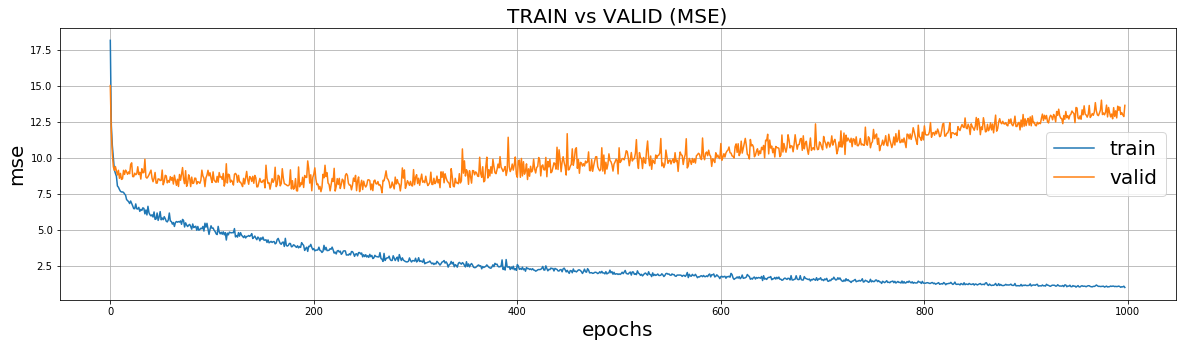

In [14]:
plt.figure(figsize=(20,5))
plt.plot(hist.history['loss'][2:], label='train')
plt.plot(hist.history['val_loss'][2:], label='valid')
plt.title('TRAIN vs VALID (MSE)', size=20)
plt.xlabel('epochs', size=20)
plt.ylabel('mse', size=20)
plt.legend(fontsize=20)
plt.grid()
plt.show()

# 재학습 - 조기종료
- validation의 성능을 보고 과적합 되기 전에 훈련을 종료 하는 방법.


In [15]:
# batch_size=4
# epochs=200

decay_st = (len(normed_train_data)//batch_size+1)*epochs
poly_sche = tf.keras.optimizers.schedules.PolynomialDecay(0.001, decay_st, end_learning_rate=1e-6, power=0.9)
opt_poly = tf.keras.optimizers.Adam(poly_sche)

model = build_model()
model.compile(loss='mse', optimizer=opt_poly, metrics=['mae','mse'])

cp = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15)
hist = model.fit(normed_train_data, train_labels, epochs=epochs, validation_split=0.2, verbose=1, batch_size=4, callbacks=[cp])

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 9)]               0         
_________________________________________________________________
Fully_connected_layer1 (Dens (None, 64)                640       
_________________________________________________________________
Fully_connected_layer2 (Dens (None, 64)                4160      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________
Train on 251 samples, validate on 63 samples
Epoch 1/1000
251/251 [==============================] - 1s 2ms/sample - loss: 456.8747 - mae: 19.9915 - mse: 456.8747 - val_loss: 272.5631 - val_mae: 15.0144 - val_mse: 272.5631
Epoch 2/1000
251/251 [==========

251/251 [==============================] - 0s 670us/sample - loss: 6.5957 - mae: 1.7972 - mse: 6.5957 - val_loss: 8.4329 - val_mae: 2.3087 - val_mse: 8.4329
Epoch 44/1000
251/251 [==============================] - 0s 651us/sample - loss: 6.0495 - mae: 1.6935 - mse: 6.0495 - val_loss: 8.0910 - val_mae: 2.1607 - val_mse: 8.0910
Epoch 45/1000
251/251 [==============================] - 0s 569us/sample - loss: 6.1676 - mae: 1.7787 - mse: 6.1676 - val_loss: 8.2084 - val_mae: 2.2293 - val_mse: 8.2084
Epoch 46/1000
251/251 [==============================] - 0s 651us/sample - loss: 5.7771 - mae: 1.6807 - mse: 5.7771 - val_loss: 8.1613 - val_mae: 2.2677 - val_mse: 8.1613


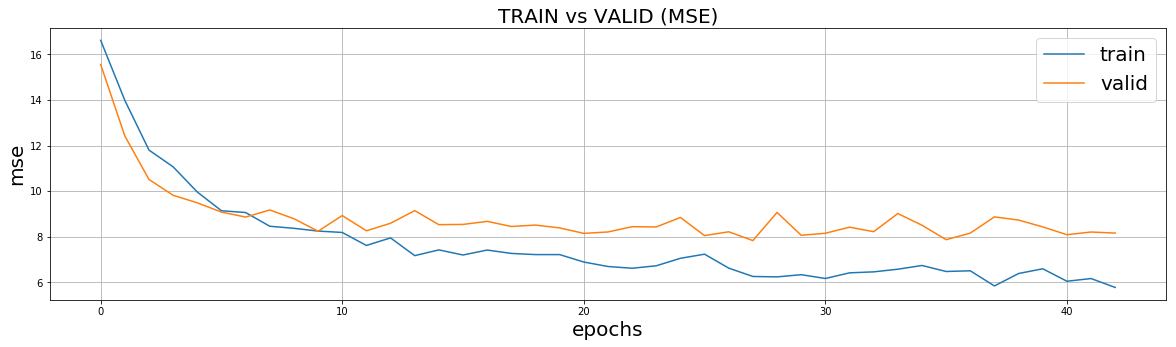

In [16]:
plt.figure(figsize=(20,5))
plt.plot(hist.history['loss'][3:], label='train')
plt.plot(hist.history['val_loss'][3:], label='valid')
plt.title('TRAIN vs VALID (MSE)', size=20)
plt.xlabel('epochs', size=20)
plt.ylabel('mse', size=20)
plt.grid()
plt.legend(fontsize=20)
plt.show()

# 테스트 데이터로 모델 성능 최종 확인

In [17]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)
print('테스트 세트의 평균 절대 오차 : {:.2f} MPG'.format(mse))

78/78 - 0s - loss: 5.6387 - mae: 1.8248 - mse: 5.6387
테스트 세트의 평균 절대 오차 : 5.64 MPG


## 예측과 정답의 상관도 시각화

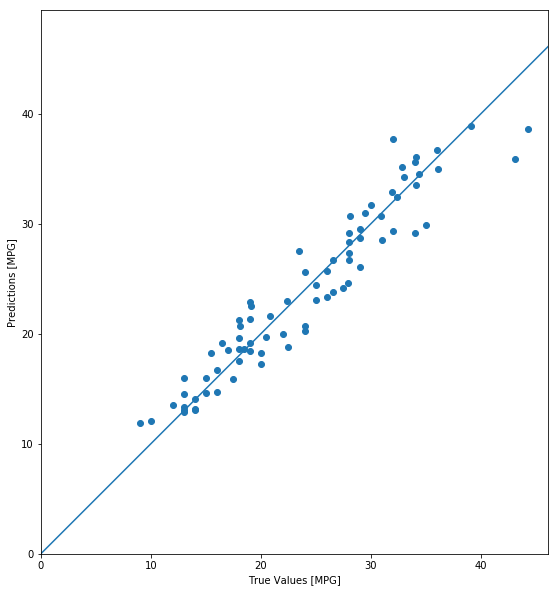

In [18]:
test_predictions = model.predict(normed_test_data).flatten()
plt.figure(figsize=(10,10))
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])


## 오차 분포

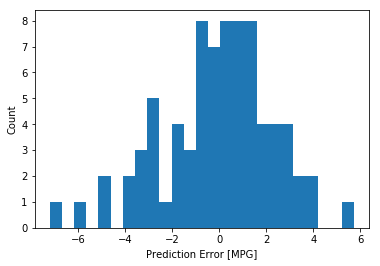

In [19]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")